In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotting_common
import os
import seaborn as sns

In [2]:
plotting_common.setup_plotting_style()

In [3]:
df = pd.read_json("data/size-comparison.json")
total_negatives = 8402298293
total_one_past = 210286406
total_positives = 187636299
total_normalized_positives = 23475688

df["rate_false_positives_in_one_past"] = df["false_positives_in_one_past"] / total_one_past
df["rate_false_positives"] = df["false_positives"] / total_negatives

df["ratio"] = df["rate_false_positives_in_one_past"] / df["rate_false_positives"]

In [4]:
base_path = "../precompute/filters/modulo/"

sizes = []

for row in df.iterrows():
    size = row[1]["size"]
    k = 1
    path = base_path + f"filter_{size:09}_{k}_norm.bin.br"
    sizes.append(os.path.getsize(path))

df["compressed_size_bytes"] = sizes

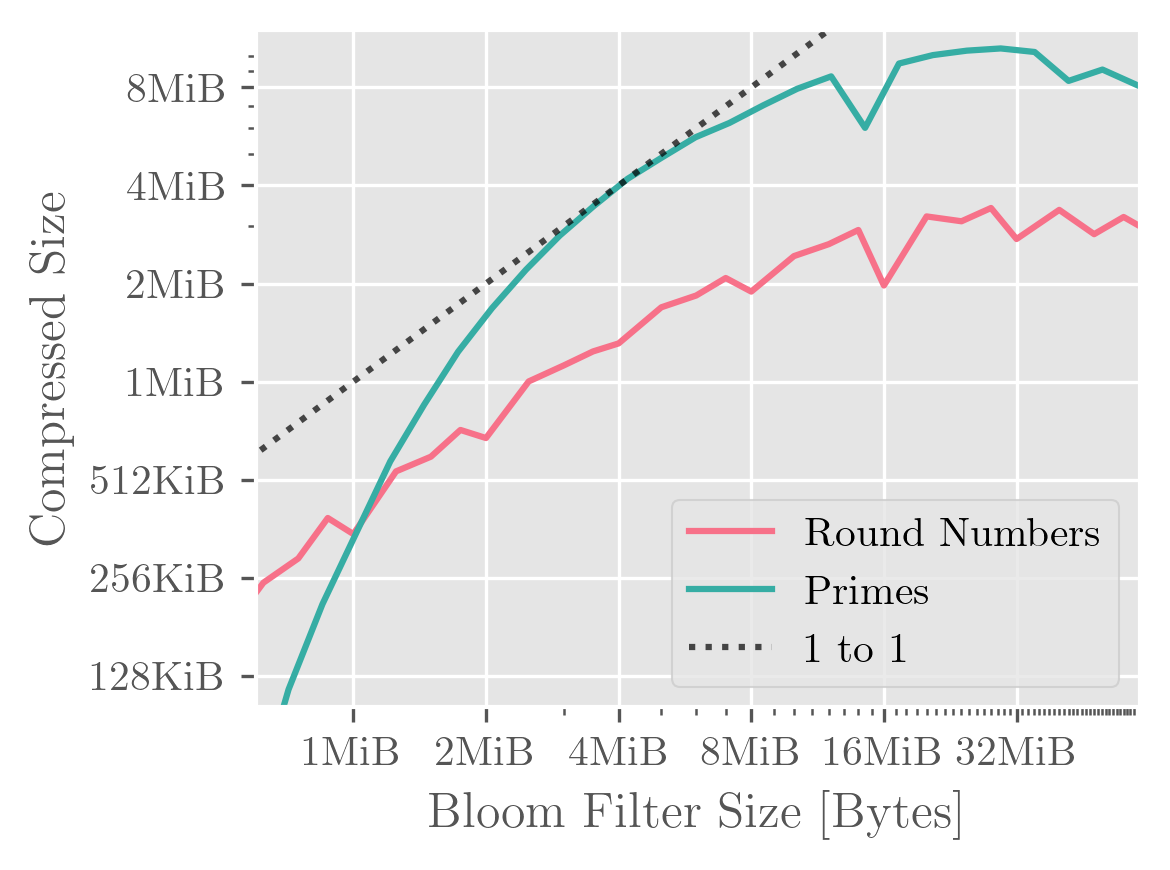

In [5]:
for category in ["round", "prime"]:
    label = {
        "round": "Round Numbers",
        "prime": "Primes",
    }[category]

    marker = plotting_common.category_markers[category]
    color = plotting_common.category_colors[category]

    data = df[df["size_category"] == category].sort_values("size")

    plt.plot(data["size"] / 8, data["compressed_size_bytes"], label=label, color=color)

x = np.sort(df["size"])

plt.plot(x / 8, x / 8, label="1 to 1", color="black", linestyle=":", alpha=0.7)

plt.xscale('log')
plt.xlabel("Bloom Filter Size [Bytes]")
plt.yscale('log')
plt.ylabel("Compressed Size")
plt.xlim(0.6 * 2**20, 61 * 2**20)
plt.ylim(0.1 * 2**20, 12 * 2**20)

plotting_common.setup_bytes_formatters(plt.gca().xaxis)
plotting_common.setup_bytes_formatters(plt.gca().yaxis)
plt.gca().xaxis.set_major_locator(plt.LogLocator(base=2))
plt.gca().yaxis.set_major_locator(plt.LogLocator(base=2))
plt.gca().xaxis.set_ticks([m * 2**20 for m in range(2, 60)], minor=True)
plt.gca().yaxis.set_ticks([m * 2**20 for m in range(1, 11)], minor=True)
plt.gcf().set_size_inches(4, 3)

plt.legend()
plt.tight_layout()
plt.savefig('../report/img/round-vs-primes-compression.pdf')


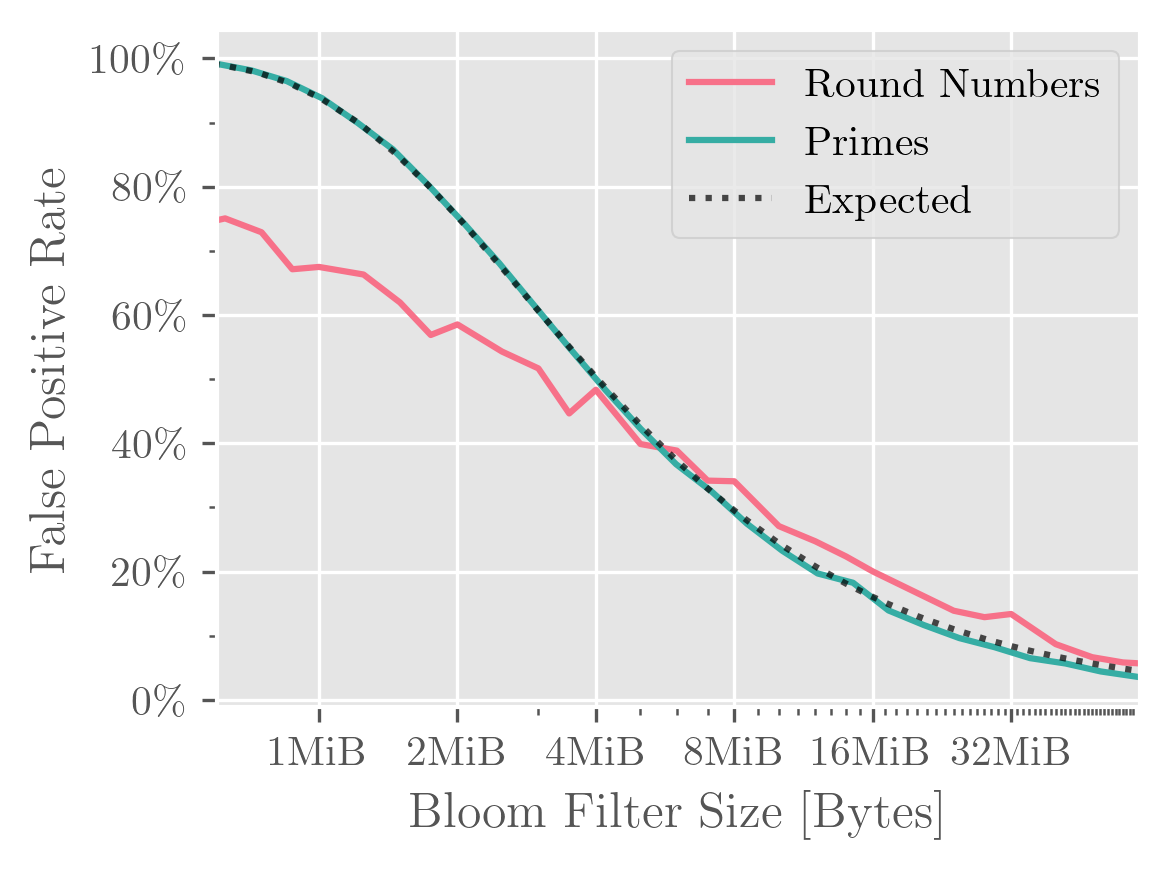

In [6]:
for category in ["round", "prime"]:
    label = {
        "round": "Round Numbers",
        "round_minus_one": "Round Numbers - 1",
        "prime": "Primes",
    }[category]

    marker = plotting_common.category_markers[category]
    color = plotting_common.category_colors[category]

    data = df[df["size_category"] == category].sort_values("size")

    plt.plot(data["size"] / 8, data["false_positives"] / total_negatives * 100, label=label, color=color)
    # plt.plot(data["size"] / 8, data["false_positives_in_one_past"] / total_one_past, label=f"{category} False Positives in One-Past", color=color, linestyle="--")

    # plt.plot(data["size"] / 8, data["ratio"], label=f"{category} Ratio", marker=marker)

k = 1
x = np.sort(df["size"])
y = np.pow(1 - np.exp(-k / (x / total_normalized_positives)), k)

plt.plot(x / 8, y * 100, label="Expected", color="black", linestyle=":", alpha=0.7)

plt.xscale('log')
plt.xlabel("Bloom Filter Size [Bytes]")
plt.ylabel("False Positive Rate")
plt.xlim(0.6 * 2**20, 61 * 2**20)
plt.gca().yaxis.set_ticks([10 * i for i in range(11)], minor=True)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: fr"{x:.0f}\%"))

plotting_common.setup_bytes_formatters(plt.gca().xaxis)
plt.gca().xaxis.set_major_locator(plt.LogLocator(base=2))
plt.gca().xaxis.set_ticks([m * 2**20 for m in range(2, 60)], minor=True)
plt.gcf().set_size_inches(4, 3)

plt.legend()
plt.tight_layout()
plt.savefig('../report/img/round-vs-primes-fpr.pdf')

In [7]:
df_stats = pd.read_json("data/solver-stats.json")
df_joined = df.join(df_stats.set_index('size'), on="size", validate="one_to_one", sort=True, rsuffix="_right")

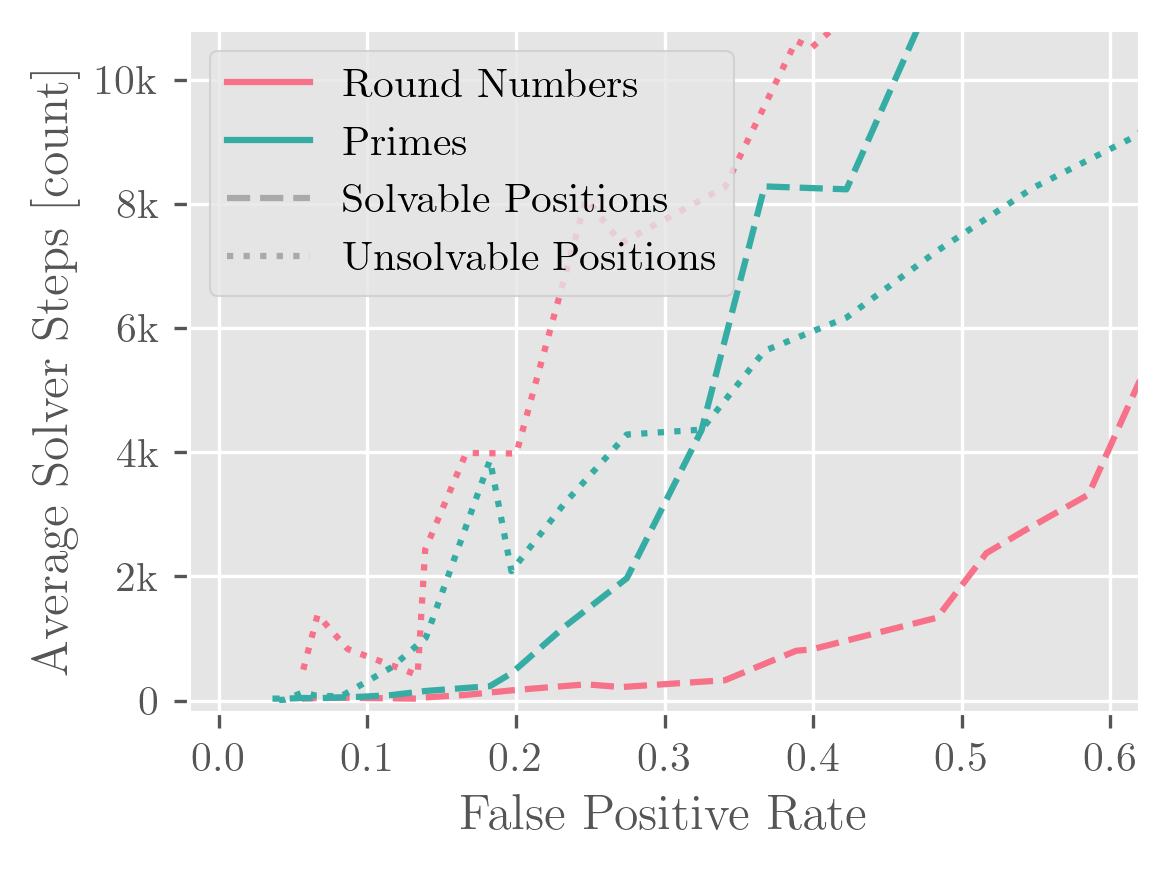

In [8]:
for category, category_name in [("round", "Round Numbers"), ("prime", "Primes")]:
    marker = plotting_common.category_markers[category]
    color = plotting_common.category_colors[category]

    data = df_joined[df_joined["size_category"] == category]
    data = data[data["size"] % 7 != 0]

    plt.plot([], [], color=color, label=f"{category_name}")
    plt.plot(data["rate_false_positives"], data["unsolvable_avg"], color=color, linestyle=":")
    plt.plot(data["rate_false_positives"], data["solvable_avg"], color=color, linestyle="--")

plt.plot([], [], linestyle="--", color="darkgray", label="Solvable Positions")
plt.plot([], [], linestyle=":", color="darkgray", label="Unsolvable Positions")

x = np.sort(df_joined["size"])
# plt.axhline(31, color="black", alpha=0.3)

def k_formatter(val, pos):
    if val >= 1000:
        return f"{val / 1000:.0f}k"
    else:
        return f"{val:.0f}"
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(k_formatter))

plt.xlabel("False Positive Rate")
plt.ylabel("Average Solver Steps [count]")
plt.ylim(-200, 10800)
plt.xlim(-0.02, 0.62)

plt.gcf().set_size_inches(4, 3)

plt.legend()
plt.tight_layout()
plt.savefig('../report/img/avg-steps-vs-rate.pdf')

In [213]:
df_joined[df_joined["unsolvable_completed"] > 0.98].sort_values("compressed_size_bytes", inplace=False)

,size,size_category,false_positives,false_positives_in_one_past,rate_false_positives_in_one_past,rate_false_positives,ratio,compressed_size_bytes,default_avg,default_completed,default_max,solvable_avg,solvable_completed,solvable_max,unsolvable_avg,unsolvable_completed,unsolvable_max
50,268435456,round,1124432841,225896,0.001074,0.133824,0.008027,2872572,31.0000,1.0,31.0,31.061081,1.0,1658.0,410.717117,0.999268,15050.0
82,536870912,round,469737219,225896,0.001074,0.055906,0.019215,3028956,31.0000,1.0,31.0,31.061081,1.0,1658.0,410.717117,0.999268,15050.0
51,335544320,round,729278426,4061834,0.019316,0.086795,0.222544,3529409,128.8749,1.0,653.0,45.499786,1.0,1667.0,828.979202,0.983459,15050.0
79,502115651,prime,303491048,7285510,0.034646,0.036120,0.959182,8543608,35.0000,1.0,35.0,31.499207,1.0,194.0,6.676880,1.000000,9149.0
25,352263649,prime,476247604,11989952,0.057017,0.056681,1.005939,8780733,34.0000,1.0,34.0,41.813919,1.0,383.0,131.549576,0.999695,15050.0
78,420567593,prime,371542973,9174138,0.043627,0.044219,0.986605,9513343,31.0000,1.0,31.0,31.017242,1.0,200.0,13.020447,1.000000,5704.0
21,173378771,prime,979419266,24558700,0.116787,0.116566,1.001898,10537306,183.0051,1.0,1118.0,89.422607,1.0,2496.0,539.330353,0.997528,15050.0
24,295052869,prime,546134094,13762033,0.065444,0.064998,1.006863,10772012,31.0000,1.0,31.0,37.370132,1.0,343.0,81.761139,0.999954,15050.0
22,206996917,prime,809060776,20408310,0.097050,0.096290,1.007889,10873951,35.0000,1.0,35.0,62.079620,1.0,956.0,261.142227,0.999939,15050.0
23,247133639,prime,689018898,17569695,0.083551,0.082004,1.018873,11045067,33.0000,1.0,33.0,51.545837,1.0,489.0,66.183182,1.000000,7816.0


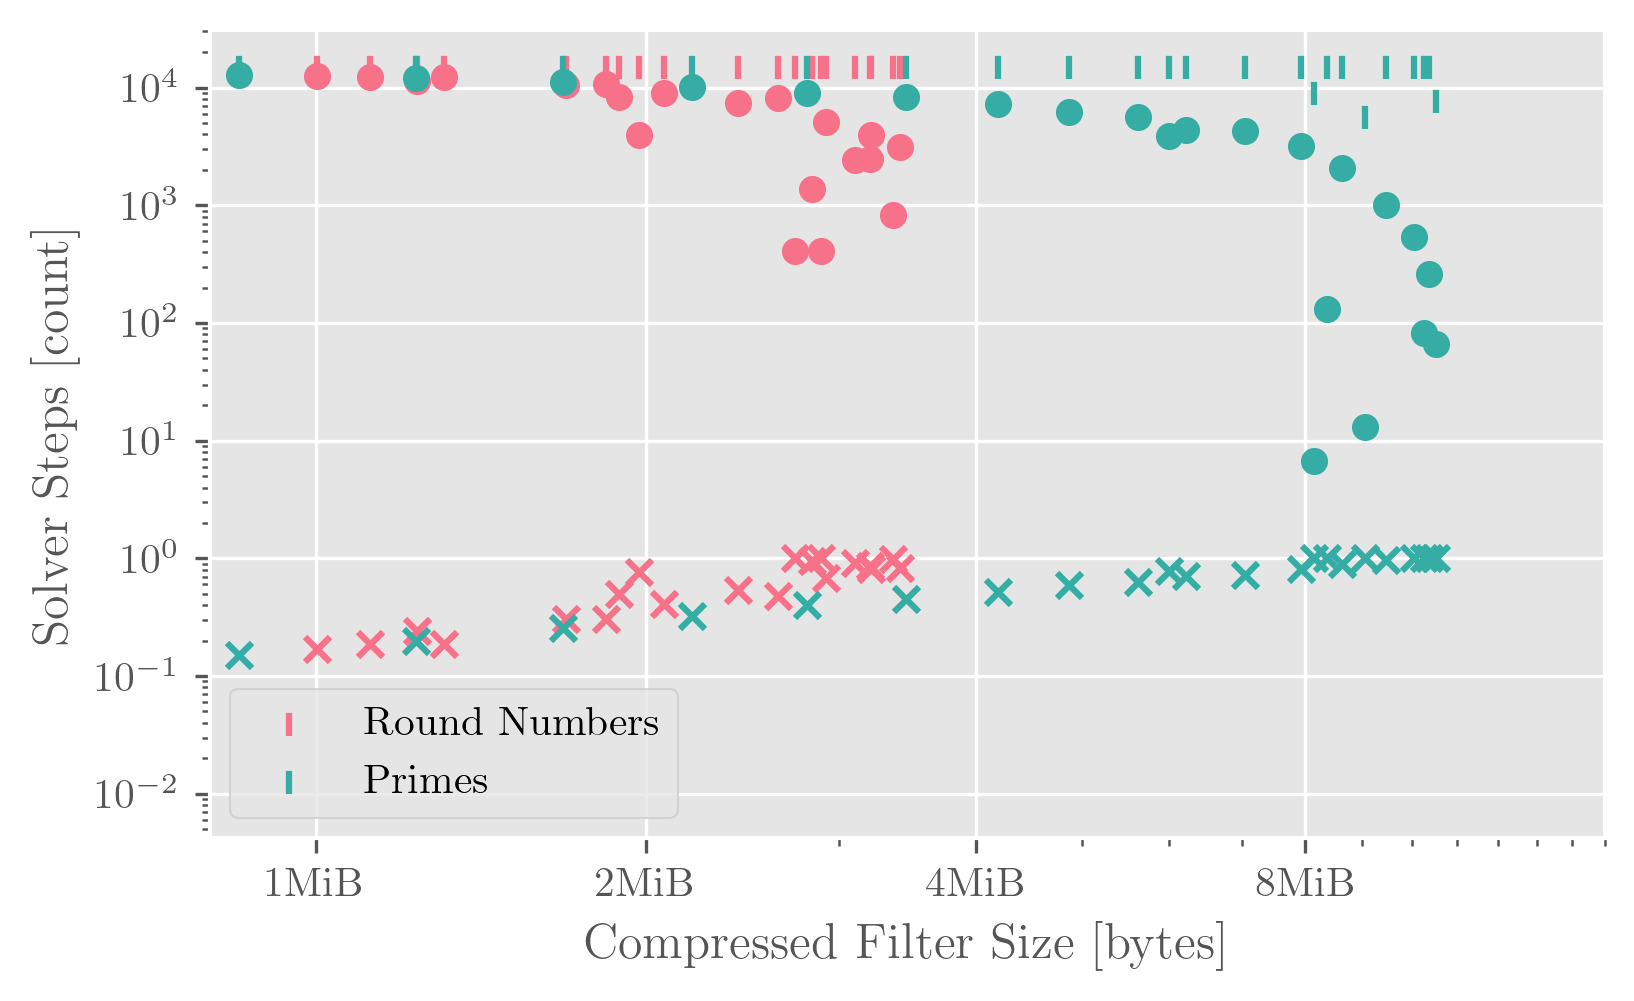

In [9]:
for category, category_name in [("round", "Round Numbers"), ("prime", "Primes")]:
    marker = plotting_common.category_markers[category]
    color = plotting_common.category_colors[category]
    color2 = (1 - color[0], 1 - color[1], 1 - color[2])

    data = df_joined[df_joined["size_category"] == category]
    # data = data[data["unsolvable_max"] < 54500]
    # data = data[data["solvable_max"] < 54500]

    u = 1
    s = 0
    d = 0
    plt.scatter(data["compressed_size_bytes"], data["unsolvable_max"] * u + data["solvable_max"] * s + data["default_max"] * d, color=color, linestyle="--", label=f"{category_name}", marker="|")
    plt.scatter(data["compressed_size_bytes"], data["unsolvable_avg"] * u + data["solvable_avg"] * s + data["default_avg"] * d, color=color)
    plt.scatter(data["compressed_size_bytes"], data["solvable_completed"] * s + data["unsolvable_completed"] * u, color=color, marker="x")

plt.xlim(0.8 * 2**20, 15 * 2**20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Compressed Filter Size [bytes]")
plt.ylabel("Solver Steps [count]")

# plt.ylim(0, 15000)
# plt.ylim(0, 150000)

plotting_common.setup_bytes_formatters(plt.gca().xaxis)
plt.gca().xaxis.set_major_locator(plt.LogLocator(base=2))
plt.gca().xaxis.set_ticks([m * 2**20 for m in range(2, 16)], minor=True)
plt.gcf().set_size_inches(6, 3.5)
plt.legend()


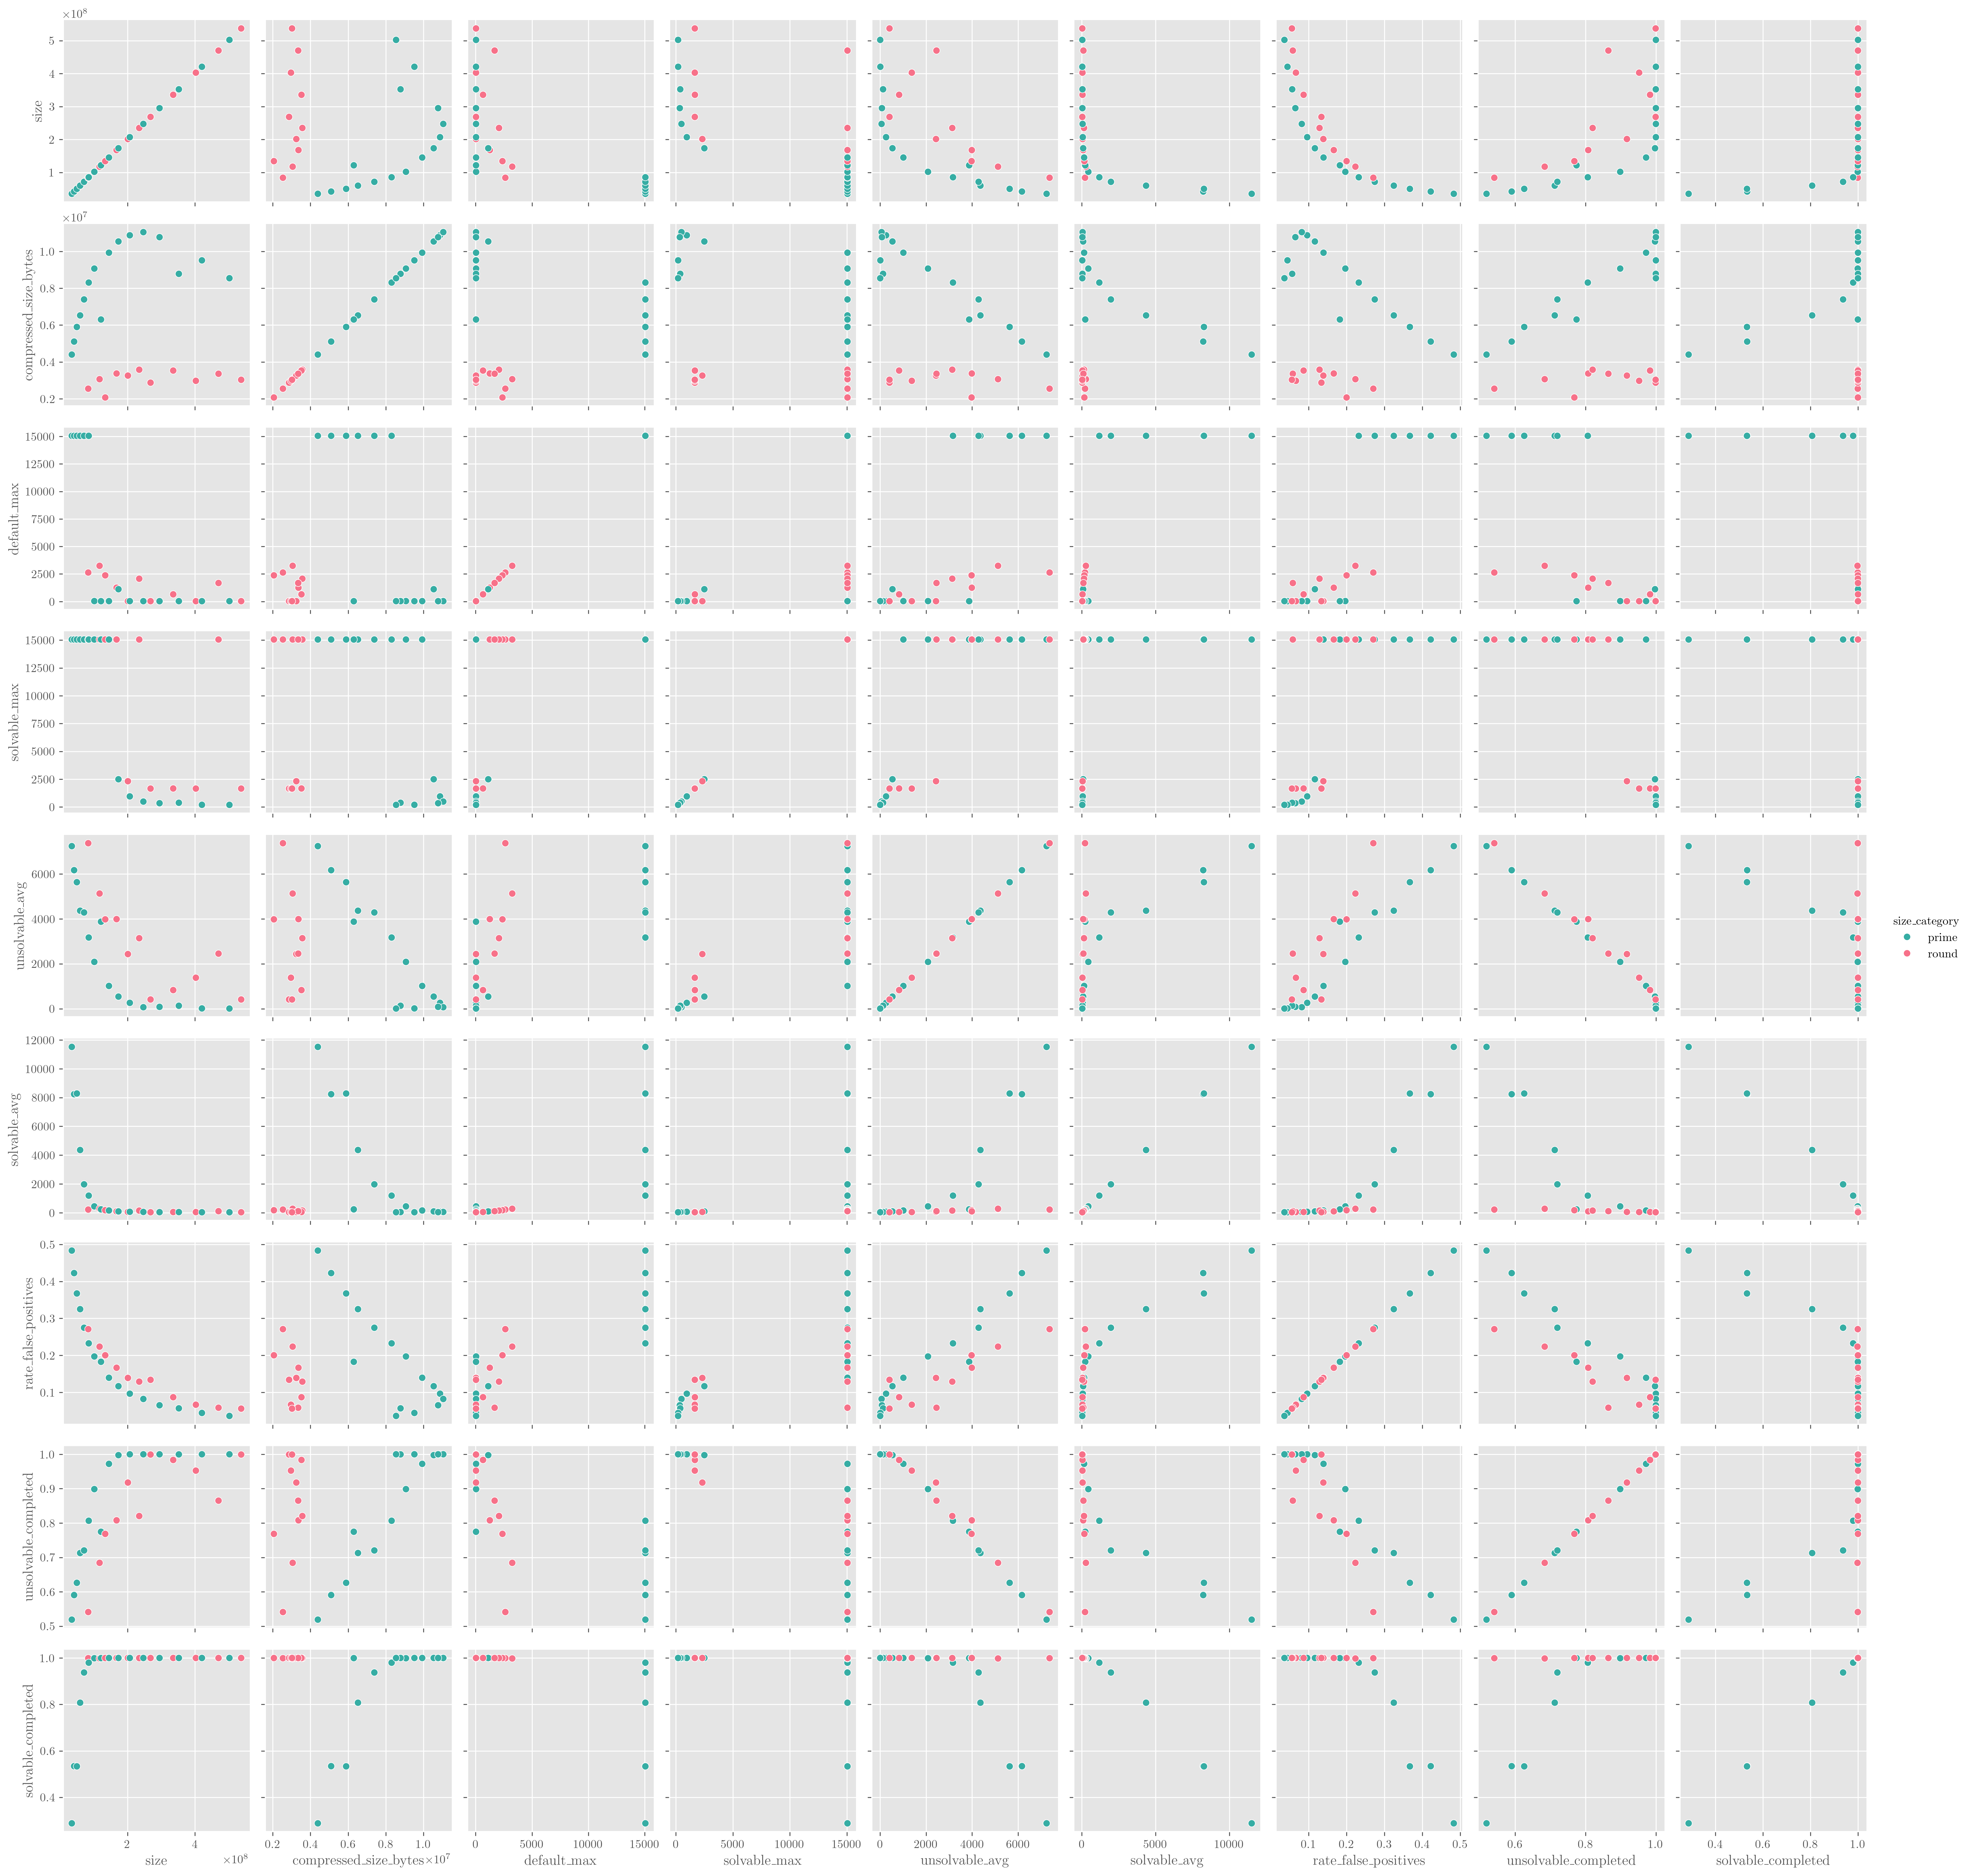

In [172]:
data=df_joined[df_joined["size_category"] != "round_minus_one"]
data=data[data["unsolvable_completed"] > 0.5]
sns.pairplot(data, hue="size_category", palette=plotting_common.category_colors, diag_kind=None, vars=("size","compressed_size_bytes", "default_max", "solvable_max", "unsolvable_avg", "solvable_avg", "rate_false_positives", "unsolvable_completed", "solvable_completed"))

In [81]:
# size 268435456 looks good

preshuffled 5 attempts cache

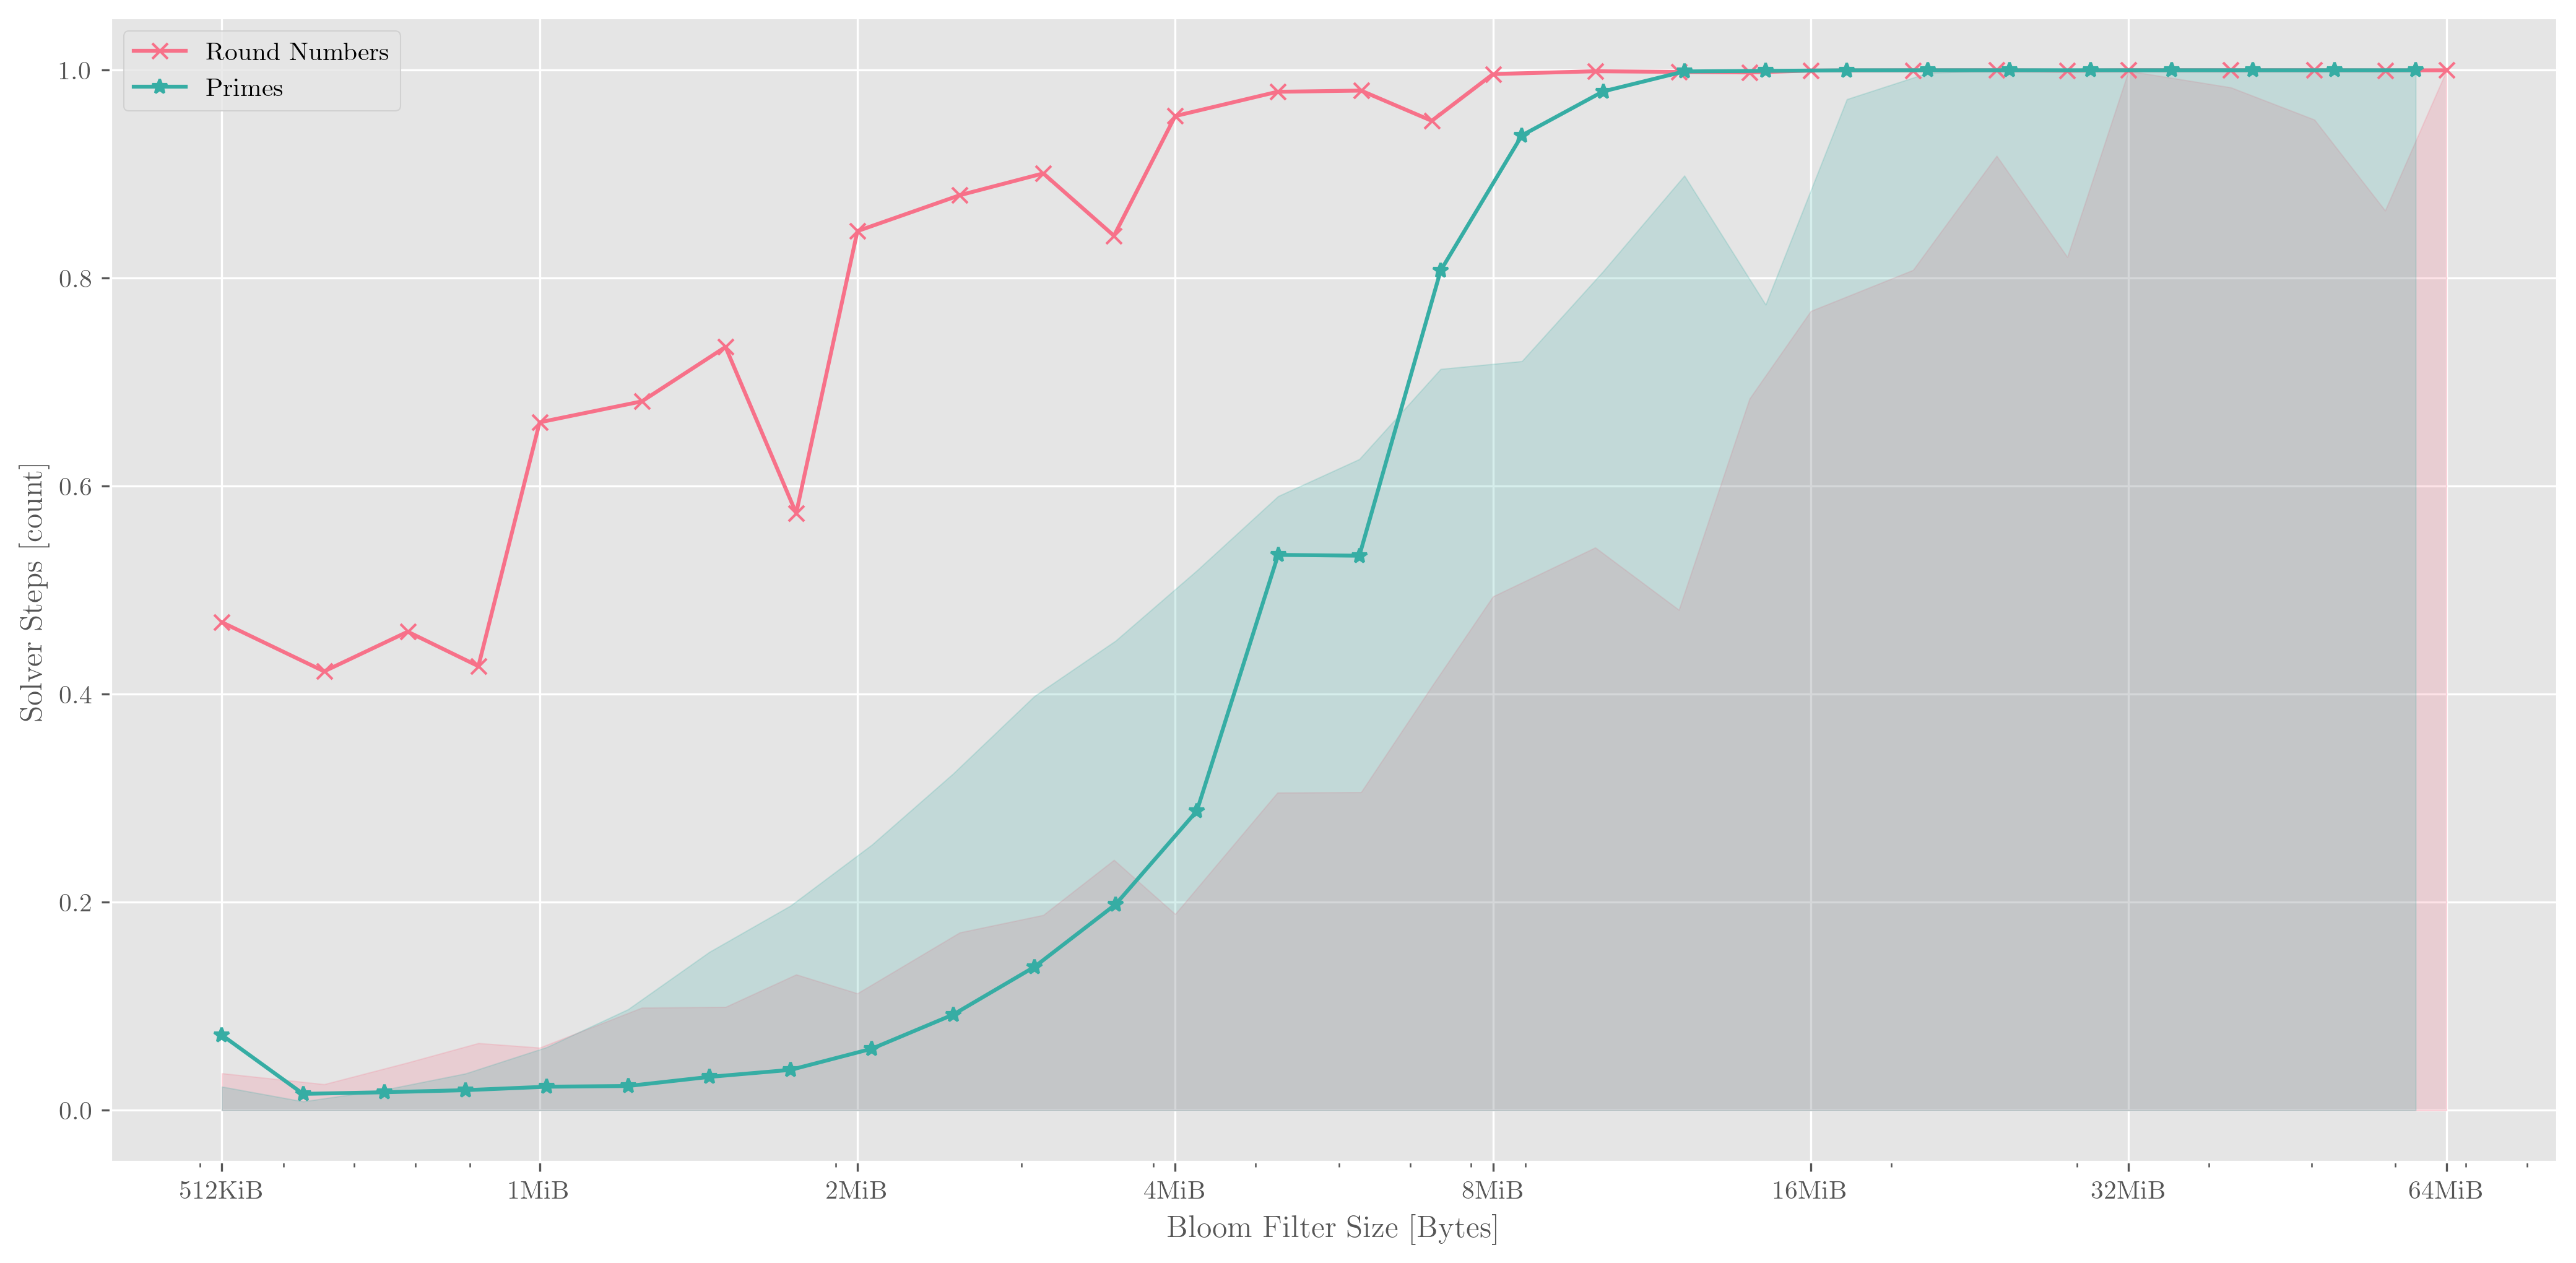

In [13]:
for category, category_name in [("round", "Round Numbers"), ("prime", "Primes")]:
    marker = plotting_common.category_markers[category]
    color = plotting_common.category_colors[category]

    data = df_joined[df_joined["size_category"] == category]

    plt.plot(data["size"] / 8, data["solvable_completed"], label=f"{category_name}", marker=marker, color=color)
    plt.fill_between(data["size"] / 8, 0, data["unsolvable_completed"], alpha=0.2, color=color)

x = np.sort(df_joined["size"])
# plt.axhline(31, color="black", alpha=0.3)

plt.xscale('log')
# plt.yscale('log')
plt.xlabel("Bloom Filter Size [Bytes]")
plt.ylabel("Solver Steps [count]")

plotting_common.setup_bytes_formatters(plt.gca().xaxis)
plt.gca().xaxis.set_major_locator(plt.LogLocator(base=2))
plt.gcf().set_size_inches(17, 8)
plt.legend()


suspense

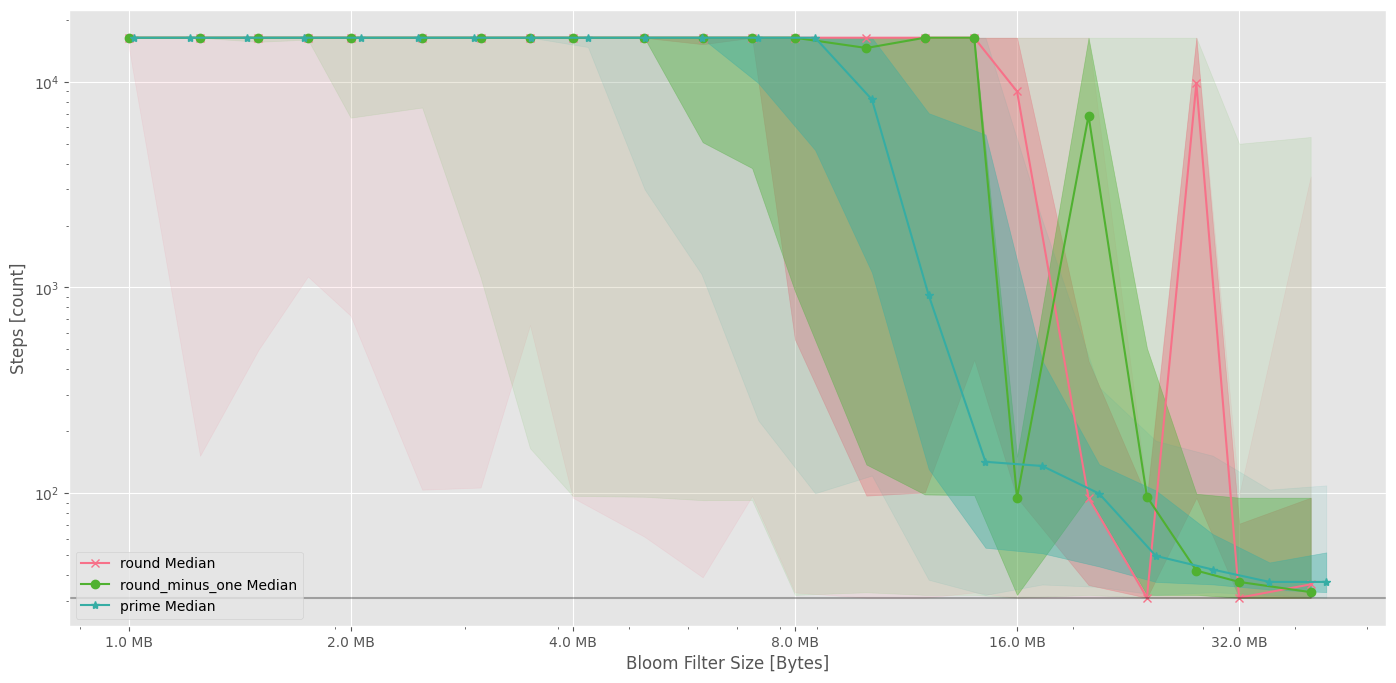

In [ ]:
for category in ["round", "round_minus_one", "prime"]:
    marker = category_markers[category]
    color = category_colors[category]

    data = df_joined[df_joined["size_category"] == category]

    plt.plot(data["size"] / 8, data["median"], label=f"{category} Median", marker=marker, color=color)
    plt.fill_between(data["size"] / 8, data["5%"], data["95%"], alpha=0.1, color=color)
    plt.fill_between(data["size"] / 8, data["25%"], data["75%"], alpha=0.4, color=color)

x = np.sort(df_joined["size"])
plt.axhline(31, color="black", alpha=0.3)

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Bloom Filter Size [Bytes]")
plt.ylabel("Steps [count]")

plotting_common.setup_bytes_formatters(plt.gca().xaxis)
plt.gca().xaxis.set_major_locator(plt.LogLocator(base=2))
plt.gcf().set_size_inches(17, 8)
plt.legend()


In [181]:
df_joined

,size,size_category,false_positives,false_positives_in_one_past,rate_false_positives_in_one_past,rate_false_positives,ratio,compressed_size_bytes,default_avg,default_completed,default_max,solvable_avg,solvable_completed,solvable_max,unsolvable_avg,unsolvable_completed,unsolvable_max
52,4194303,round_minus_one,7392119786,188005908,0.894047,0.879774,1.016224,188222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,4194304,round,6175131251,162049859,0.770615,0.734934,1.048551,168663,12678.8916,0.1942,15050.0,8995.839630,0.469299,15050.0,14518.345062,0.035660,15050.0
0,4194319,prime,7706013755,196197338,0.933001,0.917132,1.017303,163549,14893.8489,0.0134,15050.0,14198.098450,0.072372,15050.0,14707.104507,0.022797,15050.0
1,5007601,prime,8333624415,208546154,0.991724,0.991827,0.999897,52355,15031.9101,0.0015,15050.0,14872.254425,0.015854,15050.0,14921.169296,0.008560,15050.0
53,5242879,round_minus_one,7594227943,191216784,0.909316,0.903827,1.006073,217742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,402653184,round,558625538,8517300,0.040503,0.066485,0.609211,2972845,31.0000,1.0000,31.0,41.441925,1.000000,1658.0,1379.751282,0.952469,15050.0
78,420567593,prime,371542973,9174138,0.043627,0.044219,0.986605,9513343,31.0000,1.0000,31.0,31.017242,1.000000,200.0,13.020447,1.000000,5704.0
81,469762048,round,490012818,14049262,0.066810,0.058319,1.145600,3356893,220.0411,1.0000,1681.0,106.327286,0.999832,15050.0,2452.826752,0.865097,15050.0
79,502115651,prime,303491048,7285510,0.034646,0.036120,0.959182,8543608,35.0000,1.0000,35.0,31.499207,1.000000,194.0,6.676880,1.000000,9149.0


So far I prefer the prime 173378771 size (2nd value above 16MB). 21M, compresses down to 12M

compare that to the 10MB one (083886080). 11M, compresses down to 3.6M

In [4]:
total_positives / total_normalized_positives

7.992792330516576